# Testing for momentum budget fractional thickness multiplied diagnostics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
from xgcm import Grid
import dask 
import dask.distributed
%matplotlib inline

In [2]:
ppdir = "/work/Hemant.Khatri/MOM6_idealised/MOM_budget/Layer_SWM/2L/"

ds_mom = xr.open_dataset(ppdir + "TW_diag_test/mom.nc")
ds_prog = xr.open_dataset(ppdir + "TW_diag_test/prog.nc")
dsgrid = xr.open_dataset(ppdir + "ocean_month.nc")

ds = xr.merge([ds_mom, ds_prog, dsgrid])

In [3]:
ds

<xarray.Dataset>
Dimensions:           (Time: 6, xh: 400, xq: 400, yh: 200, yq: 200, zl: 2)
Coordinates:
  * Time              (Time) object 0011-01-09 00:00:00 ... 0021-04-06 00:00:00
  * xq                (xq) float64 4.0 8.0 12.0 ... 1.592e+03 1.596e+03 1.6e+03
  * yh                (yh) float64 2.0 6.0 10.0 14.0 ... 786.0 790.0 794.0 798.0
  * zl                (zl) float64 1.027e+03 1.028e+03
  * xh                (xh) float64 2.0 6.0 10.0 ... 1.59e+03 1.594e+03 1.598e+03
  * yq                (yq) float64 4.0 8.0 12.0 16.0 ... 788.0 792.0 796.0 800.0
Data variables:
    dudt              (Time, zl, yh, xq) float32 5.4909743e-09 ... nan
    dvdt              (Time, zl, yq, xh) float32 3.70199e-10 ... nan
    CAu               (Time, zl, yh, xq) float32 2.2456511e-08 ... nan
    CAv               (Time, zl, yq, xh) float32 3.7730285e-07 ... nan
    PFu               (Time, zl, yh, xq) float32 -2.6570126e-08 ... nan
    PFv               (Time, zl, yq, xh) float32 -3.910251e-07 ... 

In [4]:
grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X'])

In [5]:
H = ds['h'].sum('zl') 
h_frac = ds['h'] / H

h_fracu = grid.interp(h_frac,'X')
h_fracv = grid.interp(h_frac,'Y',boundary='fill')

Text(0, 0.5, 'y (km)')

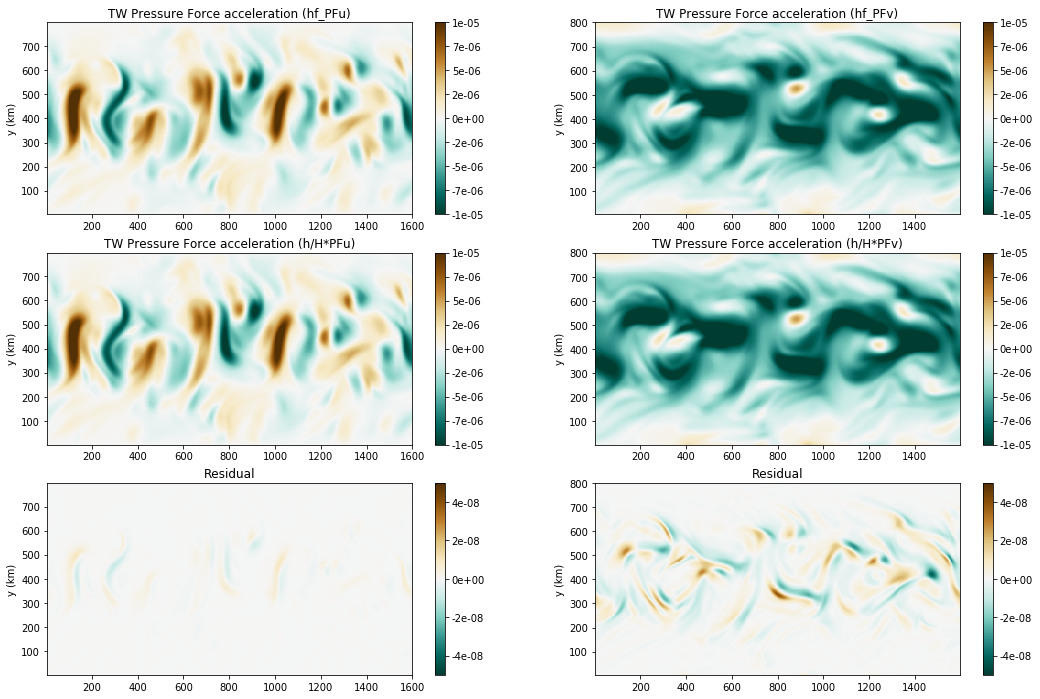

In [6]:
# Compare (h/H)Pfu and hf_Pfu (Snapshots)

tmp_PFu = h_fracu*ds['PFu']
tmp_PFv = h_fracv*ds['PFv']

idx = 2; i = 0
plt.figure(figsize=(18,12))
max_r = [1.e-5, 1.e-5]

plt.subplot(3,2,1)
plt.pcolor(ds['xq'], ds['yh'], ds['hf_PFu'].isel(Time=idx, zl=i), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('TW Pressure Force acceleration (hf_PFu)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,2)
plt.pcolor(ds['xh'], ds['yq'], ds['hf_PFv'].isel(Time=idx, zl=i), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('TW Pressure Force acceleration (hf_PFv)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,3)
plt.pcolor(ds['xq'], ds['yh'], tmp_PFu.isel(Time=idx, zl=i), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('TW Pressure Force acceleration (h/H*PFu)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,4)
plt.pcolor(ds['xh'], ds['yq'], tmp_PFv.isel(Time=idx, zl=i), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('TW Pressure Force acceleration (h/H*PFv)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,5)
plt.pcolor(ds['xq'], ds['yh'], (ds['hf_PFu']-tmp_PFu).isel(Time=idx, zl=i), vmin = -0.5e-2*max_r[i], vmax = 0.5e-2*max_r[i], cmap='BrBG_r')
plt.title('Residual')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,6)
plt.pcolor(ds['xh'], ds['yq'], (ds['hf_PFv']-tmp_PFv).isel(Time=idx, zl=i), vmin = -0.5e-2*max_r[i], vmax = 0.5e-2*max_r[i], cmap='BrBG_r')
plt.title('Residual')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

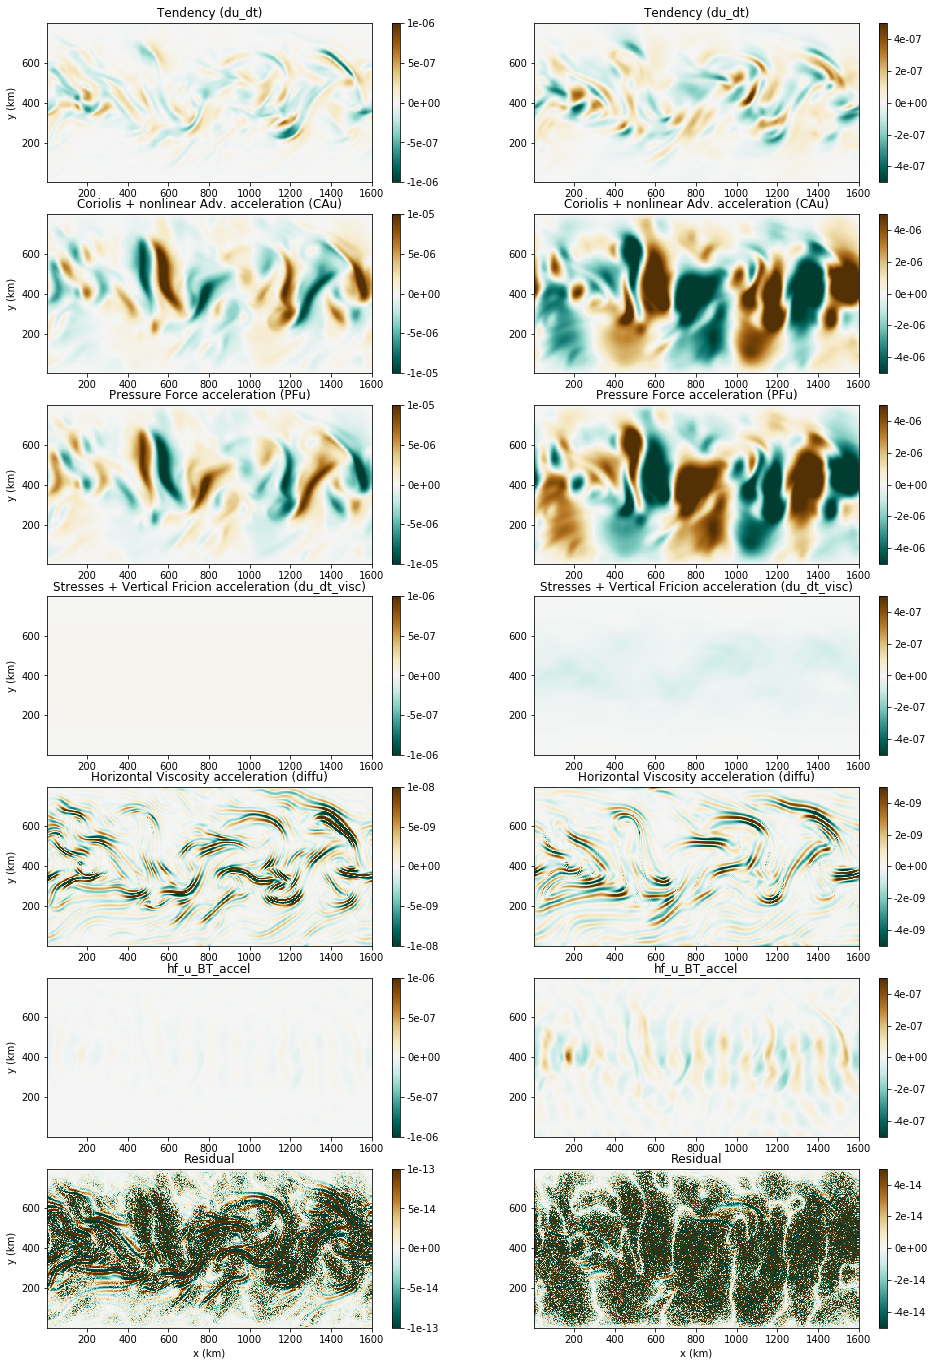

In [7]:
# Zonal Momentum budget
idx = 4
plt.figure(figsize=(16,24))
max_r = [1.e-6, 5.e-7]

for i in range(0,2):
    plt.subplot(7,2, i+1)
    plt.pcolormesh(ds['xq'], ds['yh'], ds['hf_dudt'].isel(Time=idx, zl=i), vmin = -max_r[i], 
             vmax = max_r[i], cmap='BrBG_r')
    plt.title('Tendency (du_dt)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(7,2, i+3)
    plt.pcolor(ds['xq'], ds['yh'], (ds['hf_CAu']).isel(Time=idx, zl=i), vmin = -1.e1*max_r[i], 
             vmax = 1.e1*max_r[i], cmap='BrBG_r')
    plt.title('Coriolis + nonlinear Adv. acceleration (CAu)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(7,2, i+5)
    plt.pcolor(ds['xq'], ds['yh'], ds['hf_PFu'].isel(Time=idx, zl=i), vmin = -1.e1*max_r[i], 
             vmax = 1.e1*max_r[i], cmap='BrBG_r')
    plt.title('Pressure Force acceleration (PFu)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(7,2, i+7)
    plt.pcolor(ds['xq'], ds['yh'], ds['hf_du_dt_visc'].isel(Time=idx, zl=i), vmin = -max_r[i], 
             vmax = max_r[i], cmap='BrBG_r')
    plt.title('Stresses + Vertical Fricion acceleration (du_dt_visc)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(7,2, i+9)
    plt.pcolor(ds['xq'], ds['yh'], ds['hf_diffu'].isel(Time=idx, zl=i), vmin = -1e-2*max_r[i], 
             vmax = 1e-2*max_r[i], cmap='BrBG_r')
    plt.title('Horizontal Viscosity acceleration (diffu)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
        
    plt.subplot(7,2, i+11)
    plt.pcolor(ds['xq'], ds['yh'], ds['hf_u_BT_accel'].isel(Time=idx, zl=i), vmin = -max_r[i], 
             vmax = max_r[i], cmap='BrBG_r')
    plt.title('hf_u_BT_accel')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(7,2, i+13)
    plt.pcolor(ds['xq'], ds['yh'], (ds['hf_dudt']-ds['hf_CAu']-ds['hf_PFu']-ds['hf_diffu']-ds['hf_du_dt_visc']).isel(Time=idx, zl=i)
               - ds['hf_u_BT_accel'].isel(Time = idx, zl=i), vmin = -1e-7*max_r[i], vmax = 1e-7*max_r[i], cmap='BrBG_r')
    plt.xlabel('x (km)')
    plt.title('Residual')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')

Text(0.5, 0, 'x (km)')

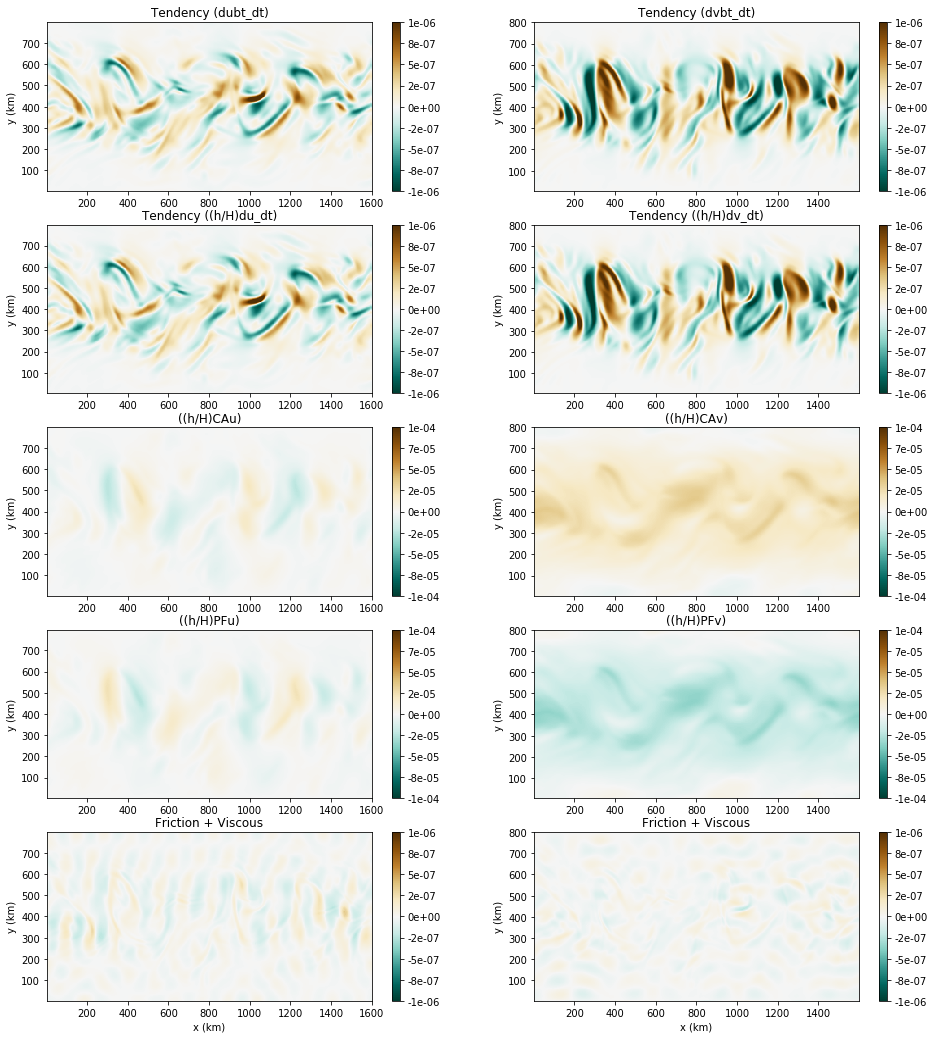

In [8]:
# Barotropic momentum budget

idx = 3

i = 0
plt.figure(figsize=(16,18))
max_r = [1.e-6, 1.e-6]

plt.subplot(5,2,1)
plt.pcolormesh(ds['xq'], ds['yh'], ds['ubt_dt'].isel(Time=idx), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('Tendency (dubt_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,2)
plt.pcolormesh(ds['xh'], ds['yq'], ds['vbt_dt'].isel(Time=idx), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('Tendency (dvbt_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,3)
plt.pcolormesh(ds['xq'], ds['yh'], ds['hf_dudt_2d'].isel(Time=idx), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('Tendency ((h/H)du_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,4)
plt.pcolormesh(ds['xh'], ds['yq'], ds['hf_dvdt_2d'].isel(Time=idx), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('Tendency ((h/H)dv_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,5)
plt.pcolormesh(ds['xq'], ds['yh'], ds['hf_CAu_2d'].isel(Time=idx), vmin = -1e2*max_r[i], vmax = 1e2*max_r[i], cmap='BrBG_r')
plt.title('((h/H)CAu)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,6)
plt.pcolormesh(ds['xh'], ds['yq'], ds['hf_CAv_2d'].isel(Time=idx), vmin = -1e2*max_r[i], vmax = 1e2*max_r[i], cmap='BrBG_r')
plt.title('((h/H)CAv)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,7)
plt.pcolormesh(ds['xq'], ds['yh'], ds['hf_PFu_2d'].isel(Time=idx), vmin = -1e2*max_r[i], vmax = 1e2*max_r[i], cmap='BrBG_r')
plt.title('((h/H)PFu)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,8)
plt.pcolormesh(ds['xh'], ds['yq'], ds['hf_PFv_2d'].isel(Time=idx), vmin = -1e2*max_r[i], vmax = 1e2*max_r[i], cmap='BrBG_r')
plt.title('((h/H)PFv)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,9)
plt.pcolormesh(ds['xq'], ds['yh'], (ds['hf_du_dt_visc_2d'] + ds['hf_diffu_2d'] +ds['hf_u_BT_accel_2d']).isel(Time=idx), 
               vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('Friction + Viscous')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.xlabel('x (km)')

plt.subplot(5,2,10)
plt.pcolormesh(ds['xh'], ds['yq'], (ds['hf_dv_dt_visc_2d'] + ds['hf_diffv_2d'] +ds['hf_v_BT_accel_2d']).isel(Time=idx),
               vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('Friction + Viscous')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.xlabel('x (km)')

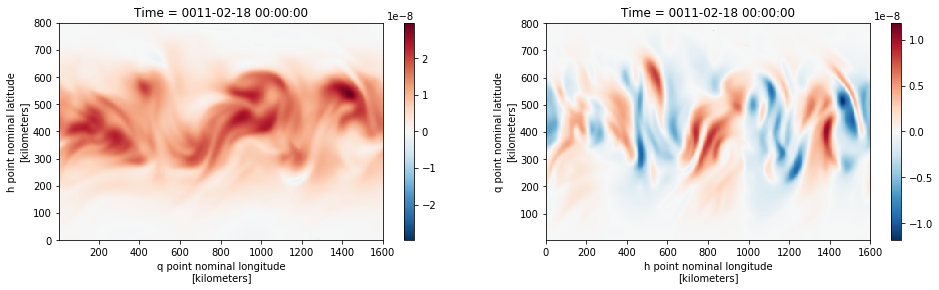

In [9]:
idx = 4
plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
(ds['ubt_dt'] - ds['hf_dudt_2d']).isel(Time=idx).plot()

plt.subplot(1,2,2)
(ds['vbt_dt'] - ds['hf_dvdt_2d']).isel(Time=idx).plot()

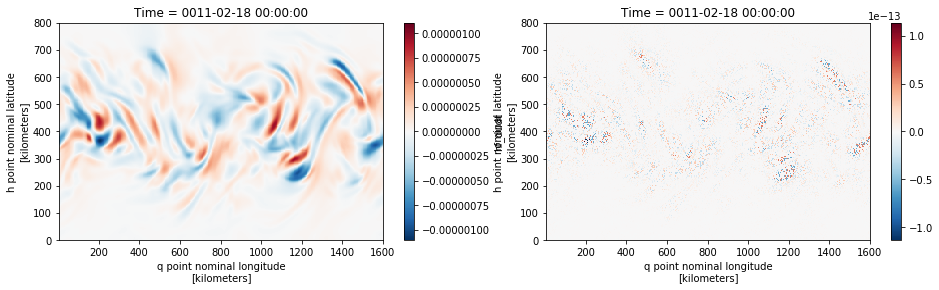

In [10]:
idx = 4
plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
ds['hf_dudt'].isel(Time=idx).sum('zl').plot()

plt.subplot(1,2,2)
(ds['hf_dudt'].isel(Time=idx).sum('zl') - ds['hf_dudt_2d'].isel(Time=idx)).plot()

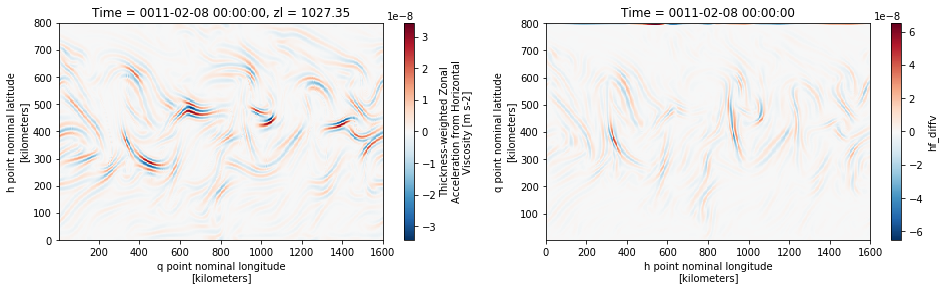

In [28]:
idx = 4
plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
ds['hf_diffu'].isel(Time=3, zl=0).plot()

plt.subplot(1,2,2)
ds['hf_diffv'].isel(Time=3).sum('zl').plot()

Text(0, 0.5, 'y (km)')

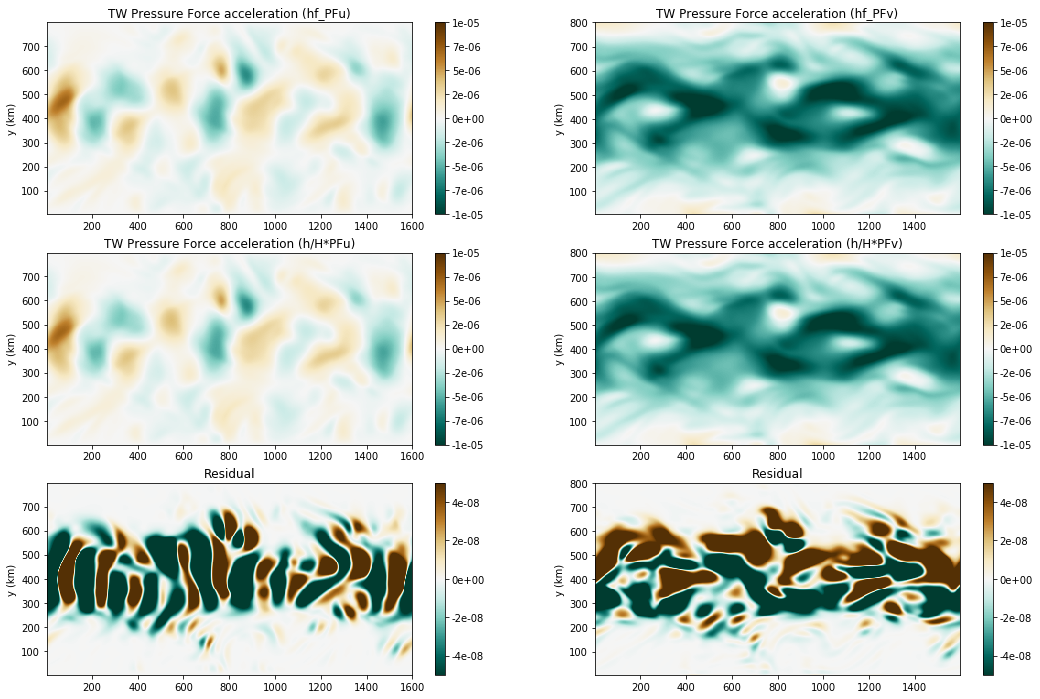

In [25]:
# Compare (h/H)Pfu and hf_Pfu (10-day averaged fields)
# These do not match well. This shows why we should prefer to compute diagnostics online.

tmp_PFu = h_fracu*ds['PFu']
tmp_PFv = h_fracv*ds['PFv']

idx = 2; i = 0
plt.figure(figsize=(18,12))
max_r = [1.e-5, 1.e-5]

plt.subplot(3,2,1)
plt.pcolor(ds['xq'], ds['yh'], ds['hf_PFu'].isel(Time=idx, zl=i), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('TW Pressure Force acceleration (hf_PFu)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,2)
plt.pcolor(ds['xh'], ds['yq'], ds['hf_PFv'].isel(Time=idx, zl=i), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('TW Pressure Force acceleration (hf_PFv)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,3)
plt.pcolor(ds['xq'], ds['yh'], tmp_PFu.isel(Time=idx, zl=i), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('TW Pressure Force acceleration (h/H*PFu)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,4)
plt.pcolor(ds['xh'], ds['yq'], tmp_PFv.isel(Time=idx, zl=i), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('TW Pressure Force acceleration (h/H*PFv)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,5)
plt.pcolor(ds['xq'], ds['yh'], (ds['hf_PFu']-tmp_PFu).isel(Time=idx, zl=i), vmin = -0.5e-2*max_r[i], vmax = 0.5e-2*max_r[i], cmap='BrBG_r')
plt.title('Residual')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,6)
plt.pcolor(ds['xh'], ds['yq'], (ds['hf_PFv']-tmp_PFv).isel(Time=idx, zl=i), vmin = -0.5e-2*max_r[i], vmax = 0.5e-2*max_r[i], cmap='BrBG_r')
plt.title('Residual')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

In [13]:
ds.close()

### Testing vorticity budget from depth-integrated flow

In [2]:
ppdir = "/work/Hemant.Khatri/MOM6_idealised/MOM_budget/Layer_SWM/"

ds = xr.open_dataset(ppdir + "ocean_monthly.nc", decode_times=False)
dsgrid = xr.open_dataset(ppdir + "grid.nc")
dsgrid = dsgrid.drop('Time')

ds1 = xr.open_dataset(ppdir + "prog_avg.nc", decode_times=False)
ds1 = ds1.mean('Time')

ds = xr.merge([ds, dsgrid])

In [3]:
print(ds)
print(ds1)

<xarray.Dataset>
Dimensions:             (Time: 1, nv: 2, xh: 400, xq: 400, yh: 800, yq: 800, zl: 2)
Coordinates:
  * xq                  (xq) float64 4.0 8.0 12.0 ... 1.596e+03 1.6e+03
  * yh                  (yh) float64 -1.598e+03 -1.594e+03 ... 1.598e+03
  * Time                (Time) float64 1.48e+04
  * nv                  (nv) float64 1.0 2.0
  * xh                  (xh) float64 2.0 6.0 10.0 ... 1.594e+03 1.598e+03
  * yq                  (yq) float64 -1.596e+03 -1.592e+03 ... 1.596e+03 1.6e+03
  * zl                  (zl) float64 1.027e+03 1.028e+03
Data variables:
    hf_dudt_2d          (Time, yh, xq) float64 ...
    hf_dvdt_2d          (Time, yq, xh) float64 ...
    ubt_dt              (Time, yh, xq) float64 ...
    vbt_dt              (Time, yq, xh) float64 ...
    hf_PFu_2d           (Time, yh, xq) float64 ...
    hf_PFv_2d           (Time, yq, xh) float64 ...
    hf_CAu_2d           (Time, yh, xq) float64 ...
    hf_CAv_2d           (Time, yq, xh) float64 ...
    hf_diffu

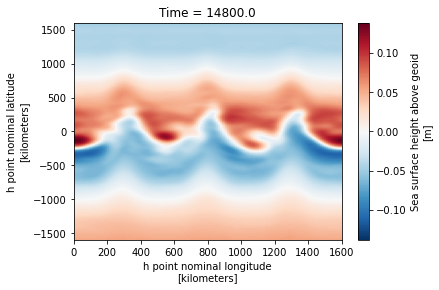

In [4]:
ds.zos.isel(Time=0).plot()

In [4]:
ds = ds.isel(Time = 0)

rho_0 = 1027.769 #ds.zl.values[0] * .25 + ds.zl.values[1] * .75 
beta = 1.5e-11

dx = 4000.; dy = 4000.
dA = dx * dy
mean_depth = 4000.

grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X'])

depth_u = grid.interp(ds['zos'] + ds['depth_ocean'], 'X',  boundary='fill')
depth_v = grid.interp(ds['zos'] + ds['depth_ocean'] , 'Y',  boundary='fill') 
depth_q = grid.interp(depth_v, 'X',  boundary='fill') 

In [5]:
vmo_z = ds['vmo_2d'] / (rho_0 * ds['dxCv'])
vmo_z = beta * grid.interp(vmo_z, 'X',  boundary='fill')

vmo_z1 = ds1['vh'].sum('zl') / ds['dxCv']
vmo_z1 = beta * grid.interp(vmo_z1, 'X',  boundary='fill')

Text(0.5, 1.0, 'Difference')

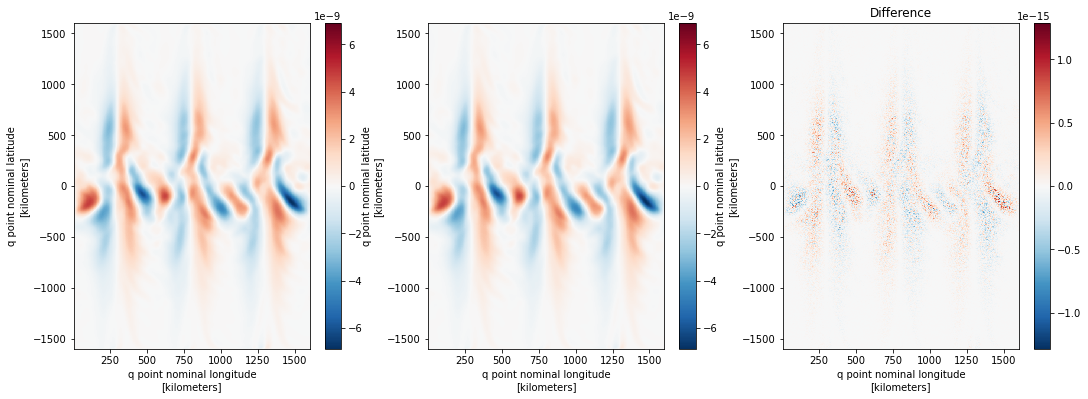

In [6]:
fig = plt.figure(figsize=[18,6])

plt.subplot(1,3,1)
vmo_z.plot()

plt.subplot(1,3,2)
vmo_z1.plot()

plt.subplot(1,3,3)
(vmo_z - vmo_z1).plot()
plt.title('Difference')

In [7]:
BPT_z = xr.Dataset()


BPT_z['vmo_bv'] = vmo_z.load()
BPT_z['vmo_bv1'] = vmo_z1.load()

BPT_1 = ( - grid.diff((ds['intz_PFu_2d'] + ds['intz_u_BT_accel_2d']) * ds.dxCu, 'Y', boundary='fill')
           + grid.diff((ds['intz_PFv_2d'] + ds['intz_v_BT_accel_2d']) * ds.dyCv, 'X', boundary='fill') 
          ) / ds.area_q

%time BPT_z['BPT'] = (BPT_1.load())

Curl_Cor2 = ( - grid.diff((ds['intz_CAu_2d'] - ds['intz_gKEu_2d'] - ds['intz_rvxv_2d'])* ds.dxCu, 'Y', boundary='fill')
           + grid.diff((ds['intz_CAv_2d'] - ds['intz_gKEv_2d'] - ds['intz_rvxu_2d'])* ds.dyCv, 'X', boundary='fill'))/ ds.area_q
%time BPT_z['Curl_Cor'] = (Curl_Cor2.load())

tmpy =  - (grid.interp(grid.interp(ds1['uh'].sum('zl') / ds['dyCu'], 'Y',  boundary='fill'), 'X',  boundary='fill')
           * grid.interp(ds['Coriolis'] , 'X',  boundary='fill'))

tmpx =  (grid.interp(grid.interp(ds1['vh'].sum('zl') / ds['dxCv'], 'Y',  boundary='fill'), 'X',  boundary='fill')
         * grid.interp(ds['Coriolis'] , 'Y',  boundary='fill'))

#tmpy = ds1['vh'].sum('zl') * grid.interp(ds['Coriolis'] , 'X',  boundary='fill')

Curl_Cor2 = ( - grid.diff(tmpx* ds.dxCu, 'Y', boundary='fill') + grid.diff(tmpy * ds.dyCv, 'X', boundary='fill'))/ ds.area_q

%time BPT_z['Curl_Cor2'] = (Curl_Cor2.load())

Curl_Cor2 = ( - grid.diff(ds['intz_u_BT_accel_2d']* ds.dxCu, 'Y', boundary='fill')
           + grid.diff(ds['intz_v_BT_accel_2d']* ds.dyCv, 'X', boundary='fill'))/ ds.area_q
%time BPT_z['Curl_u_BT_accel'] = (Curl_Cor2.load())

CPU times: user 999 µs, sys: 0 ns, total: 999 µs
Wall time: 963 µs
CPU times: user 1e+03 µs, sys: 0 ns, total: 1e+03 µs
Wall time: 1.14 ms
CPU times: user 1 ms, sys: 0 ns, total: 1 ms
Wall time: 1.18 ms
CPU times: user 1e+03 µs, sys: 0 ns, total: 1e+03 µs
Wall time: 1.25 ms


In [8]:
tmp = ( - grid.diff(ds['ubtforce']* ds.dxCu*depth_u, 'Y', boundary='fill')
           + grid.diff(ds['vbtforce']* ds.dyCv*depth_v, 'X', boundary='fill'))/ ds.area_q
%time BPT_z['Curl_ubtforce'] = (tmp.load())

tmp = ( - grid.diff(ds['u_accel_bt']* ds.dxCu*depth_u, 'Y', boundary='fill')
           + grid.diff(ds['v_accel_bt']* ds.dyCv*depth_v, 'X', boundary='fill'))/ ds.area_q
%time BPT_z['Curl_u_accel_bt'] = (tmp.load())

tmp = ( - grid.diff(ds['CoruBT']* ds.dxCu*depth_u, 'Y', boundary='fill')
           + grid.diff(ds['CorvBT']* ds.dyCv*depth_v, 'X', boundary='fill'))/ ds.area_q
%time BPT_z['Curl_CorBT'] = (tmp.load())

tmp = ( - grid.diff(ds['PFuBT']* ds.dxCu*depth_u, 'Y', boundary='fill')
           + grid.diff(ds['PFvBT']* ds.dyCv*depth_v, 'X', boundary='fill'))/ ds.area_q
%time BPT_z['Curl_PFBT'] = (tmp.load())

tmp = ( - grid.diff(ds['ubt_dt']* ds.dxCu*depth_u, 'Y', boundary='fill')
           + grid.diff(ds['vbt_dt']* ds.dyCv*depth_v, 'X', boundary='fill'))/ ds.area_q
%time BPT_z['Curl_ubtdt'] = (tmp.load())

tmp = ( - grid.diff(ds['hf_dudt_2d']* ds.dxCu*depth_u, 'Y', boundary='fill')
           + grid.diff(ds['hf_dvdt_2d']* ds.dyCv*depth_v, 'X', boundary='fill'))/ ds.area_q
%time BPT_z['Curl_hdudt'] = (tmp.load())

CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 1.38 ms
CPU times: user 999 µs, sys: 0 ns, total: 999 µs
Wall time: 1.42 ms
CPU times: user 1 ms, sys: 0 ns, total: 1 ms
Wall time: 1.51 ms
CPU times: user 1e+03 µs, sys: 0 ns, total: 1e+03 µs
Wall time: 1.58 ms
CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 1.72 ms
CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 1.75 ms


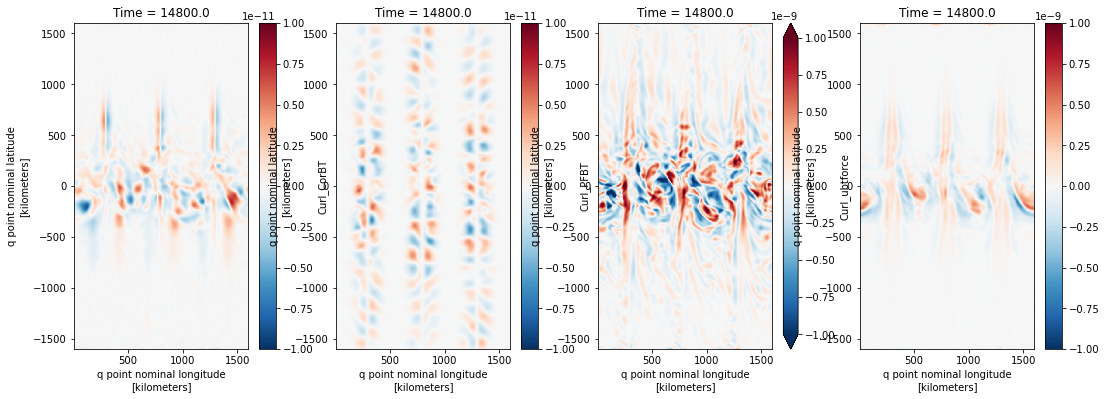

In [28]:
fig = plt.figure(figsize=[18,6])

plt.subplot(1,4,1)
BPT_z['Curl_CorBT'].plot(vmin=-1e-11, vmax=1e-11, cmap='RdBu_r')

plt.subplot(1,4,2)
BPT_z['Curl_PFBT'].plot(vmin=-1e-11, vmax=1e-11, cmap='RdBu_r')

plt.subplot(1,4,3)
BPT_z['Curl_ubtforce'].plot(vmin=-1e-9, vmax=1e-9, cmap='RdBu_r')

tmp = BPT_z['Curl_ubtforce'] + BPT_z['Curl_PFBT'] + BPT_z['Curl_CorBT'] - BPT_z['Curl_ubtdt'] - 0*BPT_z['Curl_hdudt']
plt.subplot(1,4,4)
tmp.plot(vmin=-1e-9, vmax=1e-9, cmap='RdBu_r')

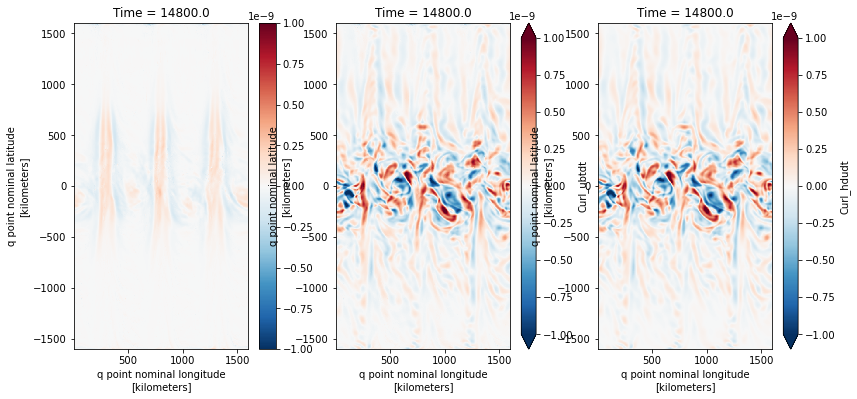

In [29]:
fig = plt.figure(figsize=[18,6])

tmp = BPT_z['Curl_ubtdt'] - BPT_z['Curl_hdudt']
plt.subplot(1,4,1)
tmp.plot(vmin=-1e-9, vmax=1e-9, cmap='RdBu_r')

plt.subplot(1,4,2)
BPT_z['Curl_ubtdt'].plot(vmin=-1e-9, vmax=1e-9, cmap='RdBu_r')
#(BPT_z['Curl_u_accel_bt'] - tmp).plot(vmin=-1e-9, vmax=1e-9, cmap='RdBu_r')

plt.subplot(1,4,3)
#(BPT_z['Curl_u_accel_bt'] - tmp - BPT_z['Curl_u_BT_accel']).plot(vmin=-1e-9, vmax=1e-9, cmap='RdBu_r')
BPT_z['Curl_hdudt'].plot(vmin=-1e-9, vmax=1e-9, cmap='RdBu_r')

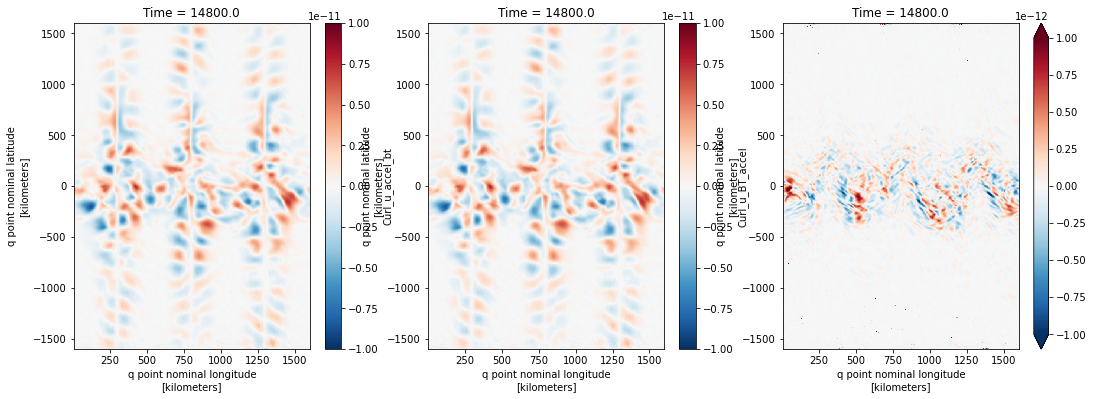

In [31]:
fig = plt.figure(figsize=[18,6])
plt.subplot(1,3,1)
(BPT_z['Curl_u_accel_bt']).plot(vmin=-1e-11, vmax=1e-11, cmap='RdBu_r')

plt.subplot(1,3,2)
(BPT_z['Curl_u_BT_accel']).plot(vmin=-1e-11, vmax=1e-11, cmap='RdBu_r')

plt.subplot(1,3,3)
(BPT_z['Curl_u_accel_bt'] - BPT_z['Curl_u_BT_accel']).plot(vmin=-1e-12, vmax=1e-12, cmap='RdBu_r')

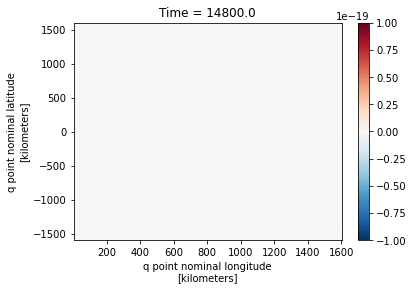

In [20]:
(BPT_z['Curl_u_accel_bt'] - BPT_z['Curl_CorBT'] - BPT_z['Curl_PFBT']).plot(vmin=-1e-19, vmax=1e-19, cmap='RdBu_r')

Text(0.5, 1.0, 'Curl of Pres Grad, z*')

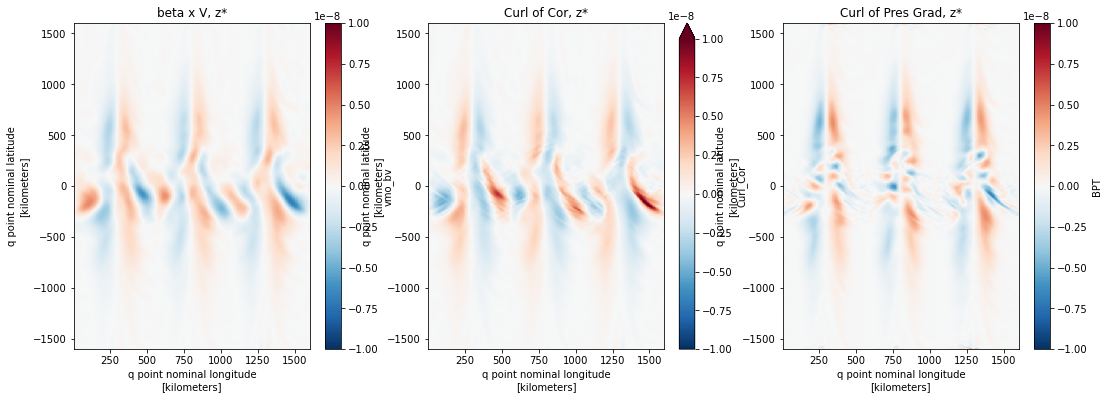

In [51]:
fig = plt.figure(figsize=[18,6])

plt.subplot(1,3,1)
BPT_z['vmo_bv'].plot(vmin=-1e-8, vmax=1e-8, cmap='RdBu_r')
plt.title('beta x V, z*')

plt.subplot(1,3,2)
BPT_z['Curl_Cor'].plot(vmin=-1e-8, vmax=1e-8, cmap='RdBu_r')
plt.title('Curl of Cor, z*')

plt.subplot(1,3,3)
BPT_z['BPT'].plot(vmin=-1e-8, vmax=1e-8, cmap='RdBu_r')
plt.title('Curl of Pres Grad, z*')

Text(0.5, 1.0, 'Difference')

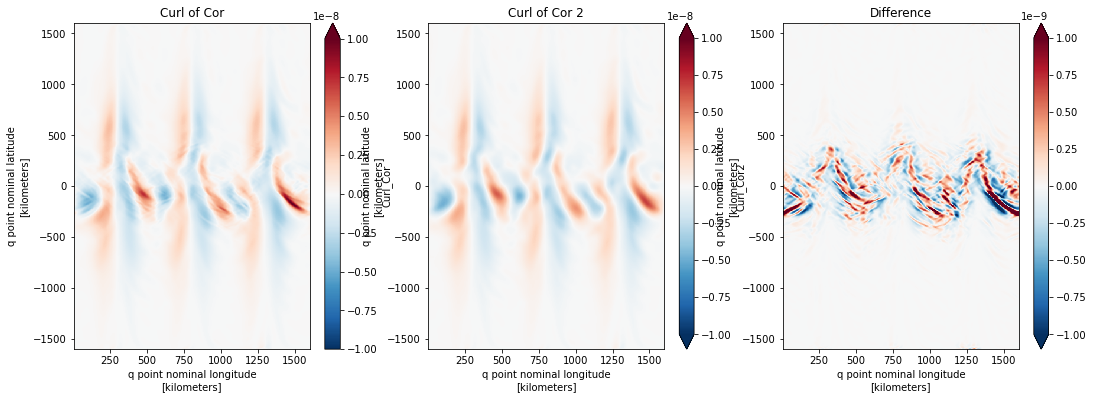

In [32]:
fig = plt.figure(figsize=[18,6])

plt.subplot(1,3,1)
BPT_z['Curl_Cor'].plot(vmin=-1e-8, vmax=1e-8, cmap='RdBu_r')
plt.title('Curl of Cor')

plt.subplot(1,3,2)
BPT_z['Curl_Cor2'].plot(vmin=-1e-8, vmax=1e-8, cmap='RdBu_r')
plt.title('Curl of Cor 2')

plt.subplot(1,3,3)
(BPT_z['Curl_Cor'] - BPT_z['Curl_Cor2']).plot(vmin=-1e-9, vmax=1e-9, cmap='RdBu_r')
plt.title('Difference')

In [23]:
div_u = (grid.diff(ds['umo_2d'] , 'X', boundary='fill')  + 
         grid.diff(ds['vmo_2d'] , 'Y', boundary='fill') ) / ( ds['area_t'] * rho_0)

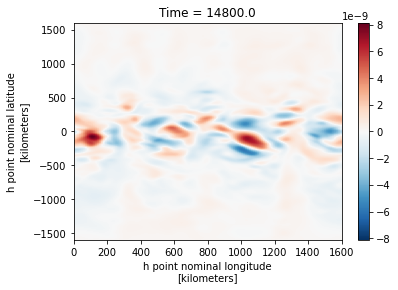

In [24]:
div_u.plot()

Text(0.5, 1.0, 'Difference')

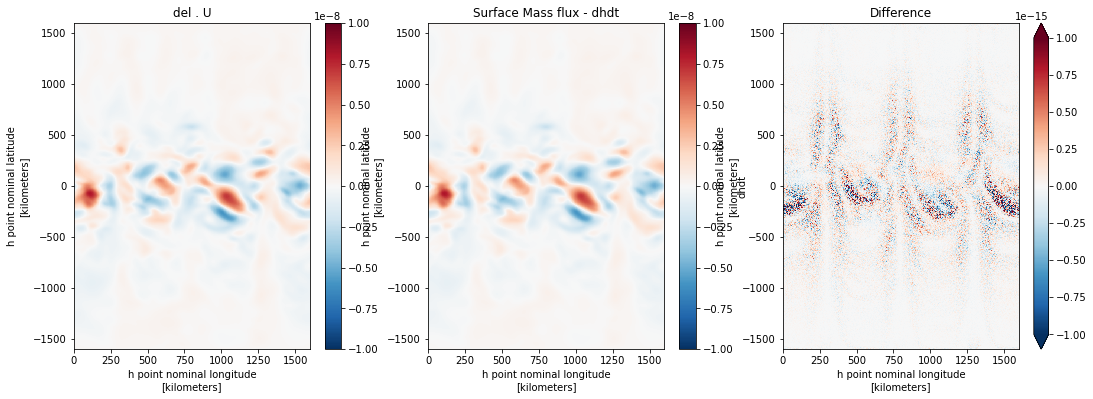

In [54]:
fig = plt.figure(figsize=[18,6])

plt.subplot(1,3,1)
div_u.plot(vmin = -1e-8, vmax = 1e-8, cmap = 'RdBu_r')
plt.title('del . U')

tmp = - ds['dhdt'].sum('zl')
plt.subplot(1,3,2)
tmp.plot(vmin = -1e-8, vmax = 1e-8, cmap = 'RdBu_r')
#(ds_z['wfo'] / rho_0).plot()
plt.title('Surface Mass flux - dhdt')

plt.subplot(1,3,3)
(div_u - tmp).plot(vmin = -1e-15, vmax = 1e-15, cmap = 'RdBu_r')
plt.title('Difference')

The curl of Coriolis term can be written as

$$ - \nabla \wedge \left( f \hat{{\bf z}} \wedge \int_{-H}^{\eta} \mathbf{u} \right) = - \beta \int_{-H}^{\eta} v - f \nabla \cdot \int_{-H}^{\eta} \mathbf{u} = - \beta \int_{-H}^{\eta} v -f \frac{Q_m}{\rho_o} + f\partial_t\eta $$

In [ ]:
f0 = -1.0e-04

fig = plt.figure(figsize=[18,6])

plt.subplot(1,3,1)
((BPT_z['Curl_Cor'] - BPT_z['Curl_ubtforce']*0 + BPT_z['vmo_bv1'])).plot(vmin=-1e-9, vmax=1e-9, cmap='RdBu_r')
plt.title('beta x V + Curl Cor.')
plt.xlabel(" ") 
plt.ylabel(" ")

tmp = (ds['dhdt'].sum('zl')) * (f0 + beta * ds['yh'])
plt.subplot(1,3,2)
tmp.plot(vmin=-1e-12, vmax=1e-12, cmap='RdBu_r')
plt.title('- Surface Mass flux + dhdt')
plt.xlabel(" ") 
plt.ylabel(" ")

plt.subplot(1,3,3)
BPT_z['vmo_bv'].plot(vmin=-1e-8, vmax=1e-8, cmap='RdBu_r')
plt.title('beta x V')
plt.xlabel(" ") 
plt.ylabel(" ")

#tmp = - (f0 + beta * ds['yh']) * div_u
#plt.subplot(1,4,4)
#tmp.plot(vmin=-1e-12, vmax=1e-12, cmap='RdBu_r')
#plt.title('- f x Divergence')
#plt.xlabel(" ") 
#plt.ylabel(" ")

Text(0, 0.5, ' ')

Text(0, 0.5, ' ')

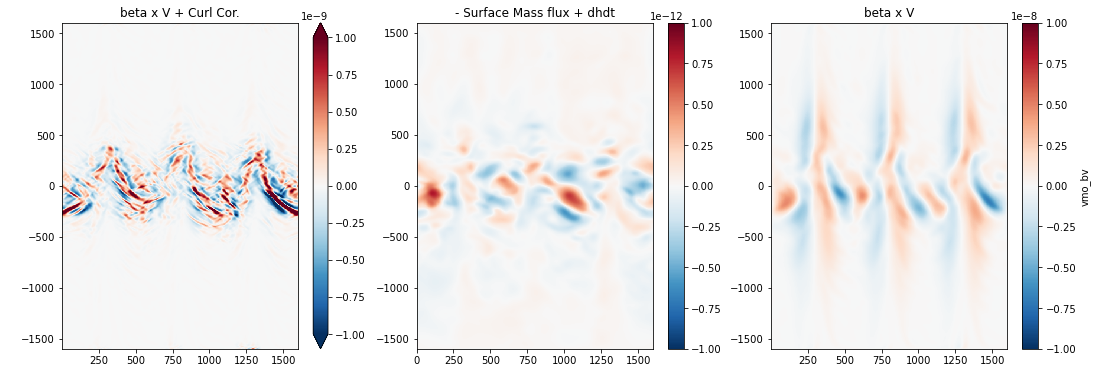

In [14]:
f0 = -1.0e-04

fig = plt.figure(figsize=[18,6])

plt.subplot(1,3,1)
((BPT_z['Curl_Cor'] + BPT_z['vmo_bv1'])).plot(vmin=-1e-9, vmax=1e-9, cmap='RdBu_r')
plt.title('beta x V + Curl Cor.')
plt.xlabel(" ") 
plt.ylabel(" ")

tmp = (ds['dhdt'].sum('zl')) * (f0 + beta * ds['yh'])
plt.subplot(1,3,2)
tmp.plot(vmin=-1e-12, vmax=1e-12, cmap='RdBu_r')
plt.title('- Surface Mass flux + dhdt')
plt.xlabel(" ") 
plt.ylabel(" ")

plt.subplot(1,3,3)
BPT_z['vmo_bv'].plot(vmin=-1e-8, vmax=1e-8, cmap='RdBu_r')
plt.title('beta x V')
plt.xlabel(" ") 
plt.ylabel(" ")

#tmp = - (f0 + beta * ds['yh']) * div_u
#plt.subplot(1,4,4)
#tmp.plot(vmin=-1e-12, vmax=1e-12, cmap='RdBu_r')
#plt.title('- f x Divergence')
#plt.xlabel(" ") 
#plt.ylabel(" ")

In [57]:
ds.close()
ds1.close()